# Ear Tracking detailed tutorial

In [1]:
%matplotlib notebook

import os
import cv2
import math as m
import numpy as np
import matplotlib.pyplot as plt

from skimage import measure

import openalea.eartrack
import openalea.eartrack.eartrack as et_lib
import openalea.eartrack.binarisation as bin
import openalea.eartrack.binarisation_folder as bin_f
from openalea.deploy.shared_data import shared_data


def img_show(imgs, titles):
    fig, axes = plt.subplots(nrows=int((len(imgs)-1)/3) + 1, ncols=min(3, len(imgs)))
    axlist = fig.get_axes()
    for i in range(len(imgs)):
        axlist[i].axis('off')
        axlist[i].set_title(titles[i])
        axlist[i].imshow(imgs[i])
        

## Get example images and parameters needed for segmentation and ear tracking

In [2]:
# Read images' information and create output folders
share_data_directory = shared_data(openalea.eartrack)
param_folder = os.path.join(share_data_directory, "parameters")
images_folder = os.path.join(share_data_directory, "images")

img_desc, parameters = bin_f.init(param_folder, images_folder, "", log=False)

## Selection of one plant and one imaging task

In [3]:
plant = img_desc.keys()[0]
task = img_desc[plant].keys()[0]

cabin = img_desc[plant][task]['cabin']

## Read images and display

<IPython.core.display.Javascript object>


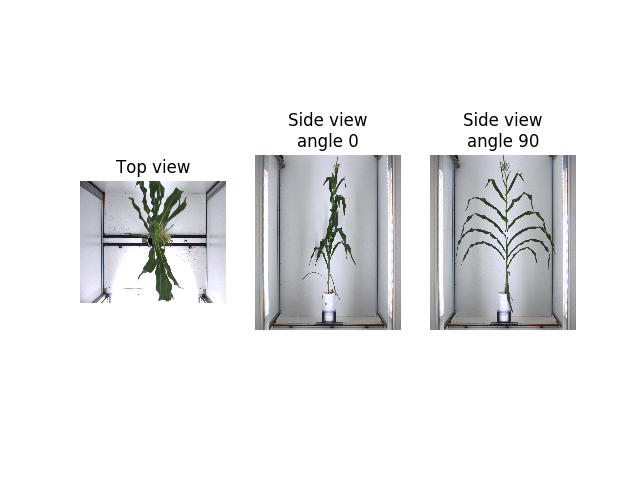

In [4]:
images = bin_f.read_images(img_desc, plant, task)

img_show([images["top"][0][:,:,::-1], images["side"][0][:,:,::-1], images["side"][90][:,:,::-1]], 
         ["Top view", "Side view\nangle 0", "Side view\nangle 90"])


## Compute binaries and display

<IPython.core.display.Javascript object>


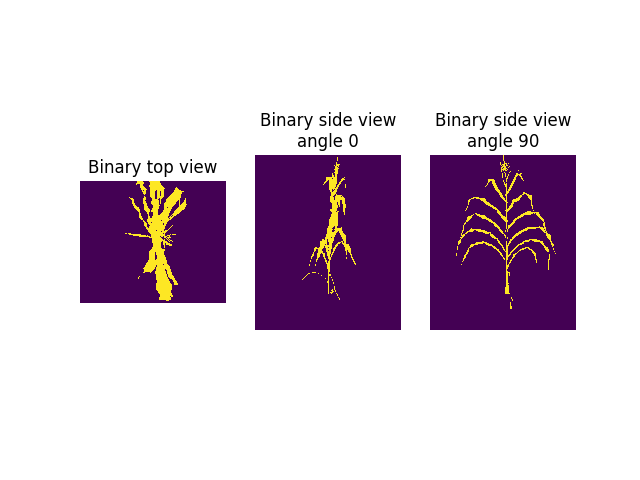

In [5]:
binaries, mask_top_center = bin_f.binaries_calculation(images, cabin, parameters)

img_show([binaries["top"][0], binaries["side"][0], binaries["side"][90]], 
         ["Binary top view", "Binary side view\nangle 0", "Binary side view\nangle 90"])

## Selection of best side view images based on top view image

### Compute robust major axis regression on top view image

<IPython.core.display.Javascript object>


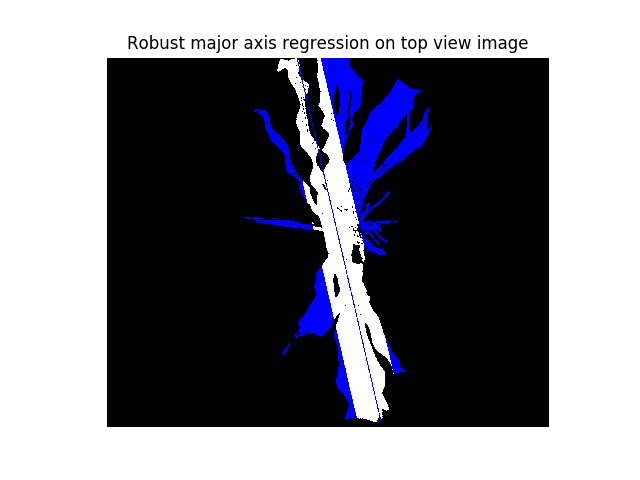

In [6]:
binary_img = binaries["top"][0].copy()
robust_img = np.zeros([binary_img.shape[0], binary_img.shape[1], 3], 'uint8')
pixels = np.where(binary_img > 0)
n = len(pixels[0])
a, b, useful_pixels, useless_pixels = et_lib.robust_majors_axes_regression_ww(pixels)
alpha = (m.atan2(a/m.sqrt(m.pow(a, 2) + 1), 1/m.sqrt(m.pow(a, 2) + 1)))*180/m.pi

a90 = -1/a
alpha90 = ((m.atan2(a90/m.sqrt(m.pow(a90, 2) + 1), 1/m.sqrt(m.pow(a90, 2) + 1)))*180/m.pi) % 360
alpha270 = (alpha90 + 180) % 360

robust_img[useful_pixels[:, 0], useful_pixels[:, 1], :] = (255, 255, 255)
robust_img[useless_pixels[:, 0], useless_pixels[:, 1], :] = (0, 0, 255)
cv2.line(robust_img, (int(b+a*pixels[0][0]), pixels[0][0]), (int(b+a*pixels[0][n-1]), pixels[0][n-1]), (0, 0, 255), 3)
cv2.line(robust_img, (int(b+a*pixels[0][0]), pixels[0][0]+2), (int(b+a*pixels[0][n-1]), pixels[0][n-1]+1), (0, 0, 255), 3)
cv2.line(robust_img, (int(b+a*pixels[0][0]), pixels[0][0]-2), (int(b+a*pixels[0][n-1]), pixels[0][n-1]-1), (0, 0, 255), 3)
img_show([robust_img], ["Robust major axis regression on top view image"])

### Compute major axis regression on useless pixels to detect hampering leaves

<IPython.core.display.Javascript object>


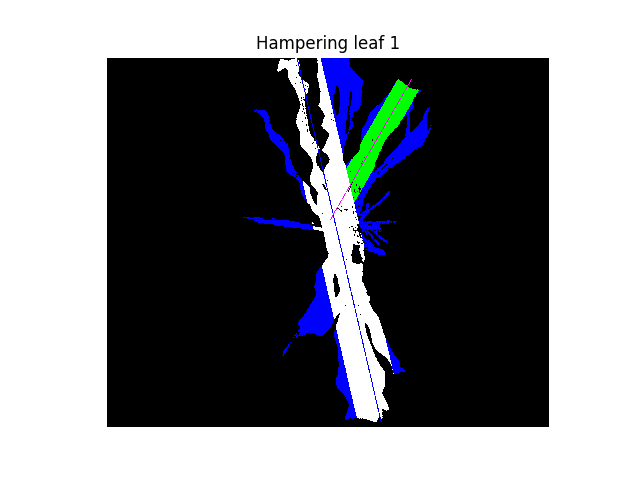

<IPython.core.display.Javascript object>


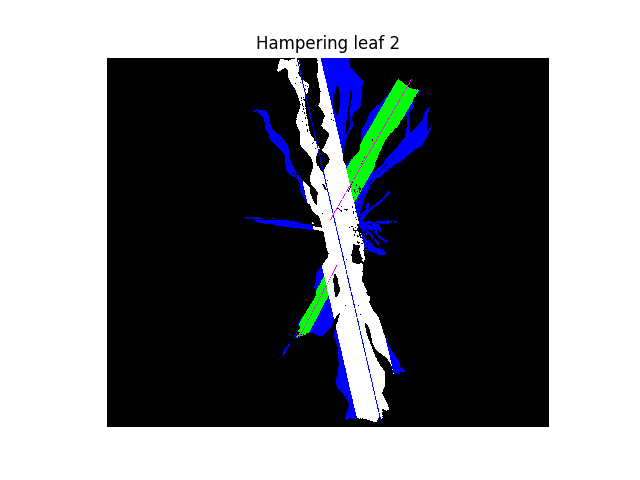

<IPython.core.display.Javascript object>


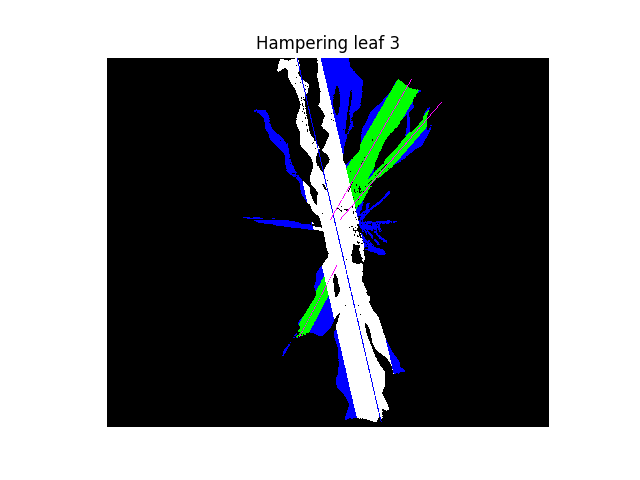

In [7]:
exclusions = list()
mask = mask_top_center
unused_pixels = useless_pixels.copy()
hampering_img = robust_img.copy()
loop_again = True
found_leaves = 0
while loop_again:
    loop_again = False
    temp_img = np.zeros(binary_img.shape, 'uint8')
    temp_img[useless_pixels[:, 0], useless_pixels[:, 1]] = 255
    useless_pixels = np.empty([0, 2], 'int')
    labelled_img = measure.label(temp_img, neighbors=8)
    for region in measure.regionprops(labelled_img):
        pixels_tmp = np.where(labelled_img == region['label'])
        used_pixels = np.transpose(np.array([pixels_tmp[0], pixels_tmp[1]]))
        n_tmp = region.area
        if n_tmp > n/20:
            a_tmp, b_tmp, useful_pixels_tmp, useless_pixels_tmp = et_lib.robust_majors_axes_regression_ww(pixels_tmp)
            alpha_tmp = (m.atan2(a_tmp/m.sqrt(m.pow(a_tmp, 2) + 1), 1/m.sqrt(m.pow(a_tmp, 2) + 1)))*180/m.pi
            errors = np.array(abs(useful_pixels_tmp[:, 1] - a * useful_pixels_tmp[:, 0] - b))
            x_intersection_line = int((b - b_tmp)/(a_tmp - a))
            y_intersection_line = int(a*x_intersection_line + b)
            useless_pixels = np.append(useless_pixels, useless_pixels_tmp, axis=0)

            if 0 <= x_intersection_line < mask.shape[0] and 0 <= y_intersection_line < mask.shape[1]:
                if abs(alpha-alpha_tmp) > 20 and mask[x_intersection_line, y_intersection_line] and  errors.max() > 300:
                    max_error_pos = np.where(errors == errors.max())[0][0]
                    max_signed_error = useful_pixels_tmp[max_error_pos, 1] - a * useful_pixels_tmp[max_error_pos, 0] - b
                    diff = alpha - alpha_tmp
                    if diff*max_signed_error < 0:
                        alpha_tmp %= 360
                    else:
                        alpha_tmp = (alpha_tmp + 180) % 360
                    exclusions.append(alpha_tmp)
                    hampering_img[useful_pixels_tmp[:, 0], useful_pixels_tmp[:, 1], :] = (0, 255, 0)
                    cv2.line(hampering_img, (int(b_tmp+a_tmp*pixels_tmp[0][0]), pixels_tmp[0][0]), 
                             (int(b_tmp+a_tmp*pixels_tmp[0][n_tmp-1]), pixels_tmp[0][n_tmp-1]), (255, 0, 255), 2)
                    cv2.line(hampering_img, (int(b_tmp+a_tmp*pixels_tmp[0][0]), pixels_tmp[0][0]+1),
                             (int(b_tmp+a_tmp*pixels_tmp[0][n_tmp-1]), pixels_tmp[0][n_tmp-1]+1), (255, 0, 255), 2)
                    cv2.line(hampering_img, (int(b_tmp+a_tmp*pixels_tmp[0][0]), pixels_tmp[0][0]-1),
                             (int(b_tmp+a_tmp*pixels_tmp[0][n_tmp-1]), pixels_tmp[0][n_tmp-1]-1), (255, 0, 255), 2)
                    found_leaves += 1
                    img_show([hampering_img], ["Hampering leaf " + str(found_leaves)])
                else:
                    hampering_img[used_pixels[:, 0], used_pixels[:, 1], :] = (0, 0, 255)
            else:
                hampering_img[used_pixels[:, 0], used_pixels[:, 1], :] = (0, 0, 255)
            loop_again = True
        else:
            hampering_img[used_pixels[:, 0], used_pixels[:, 1], :] = (0, 0, 255)


### Keep side views containing most information for ear detection

In [8]:
existing_angles = sorted(binaries["side"].keys())
angles_to_keep = list()
for angle in (alpha90, alpha270):
    if angle > 345:
        angle -= 360
    for i in range(len(existing_angles)):
        if abs(existing_angles[i] - angle) <= 10:
            if i > 0:
                angles_to_keep.append(existing_angles[i-1])
            else:
                angles_to_keep.append(existing_angles[len(existing_angles)-1])

            angles_to_keep.append(existing_angles[i])

            if i < len(existing_angles)-1:
                angles_to_keep.append(existing_angles[i+1])
            else:
                angles_to_keep.append(existing_angles[0])
            break
        elif abs(existing_angles[i] - angle) <= 15:
            angles_to_keep.append(existing_angles[i])
            if existing_angles[i] < angle:
                if i < len(existing_angles)-1:
                    angles_to_keep.append(existing_angles[i+1])
                else:
                    angles_to_keep.append(existing_angles[0])
            else:
                if i > 0:
                    angles_to_keep.append(existing_angles[i-1])
                else:
                    angles_to_keep.append(existing_angles[len(existing_angles)-1])
angles_to_keep.sort()
print("\n\nFirst step kept angles : " + ", ".join(map(str, angles_to_keep)))



First step kept angles : 90, 120, 270, 300


### Exclude side views for ear detection from hampering leaves detection

In [9]:
excluded_angles = list()
for exclude_angle in exclusions:
    exclude_negatives_angles = 1000
    if exclude_angle > 335:
        exclude_negatives_angles = exclude_angle - 360
    i = 0
    while i < len(angles_to_keep):
        if abs(exclude_angle - angles_to_keep[i]) < 25:
            excluded_angles.append(angles_to_keep.pop(i))
        elif abs(exclude_negatives_angles - angles_to_keep[i]) < 25:
            excluded_angles.append(angles_to_keep.pop(i))
        else:
            i += 1
print("\n\nSecond step excluded angles : " + ", ".join(map(str, excluded_angles)))
print("Finals kept angles : " + ", ".join(map(str, angles_to_keep)))



Second step excluded angles : 120
Finals kept angles : 90, 270, 300


## Find ear position in best side view images

### Detection on first selected side view image

In [10]:
kept_positions = np.empty([0, 3], 'int')
useful_kept_images = np.empty([0], 'int')
angle = angles_to_keep[0]
binary_img = binaries["side"][angle]
color_img = images["side"][angle]
pot_height = parameters[cabin]["side"]["pot_height"]
pot_center = parameters[cabin]["side"]["pot_width"]

binary_img = bin.close(binary_img, iterations=4)

# Get the biggest region
biggest_binary_region = et_lib.binary_biggest_region(binary_img)

# Extract skeleton of plant
output_skeleton_img = et_lib.get_skeleton(biggest_binary_region)

# Extract distance transform
dist_trans_img = et_lib.distance_transform(biggest_binary_region)

# skimage's graph library and skeleton cleaning
begin, end = et_lib.get_endpoints(output_skeleton_img, pot_center, pot_height)
if begin == [-1, -1]:
    raise ValueError( "Error in bottom's stem detection")
output_skeleton_img = et_lib.skeleton_cleaning(output_skeleton_img, begin)
route = et_lib.find_cross_route(output_skeleton_img, begin)
route.reverse()

# Make color image with distance transform 
output_dt_img = dist_trans_img*255/dist_trans_img.max()
output_dt_img = output_dt_img.astype(int)

# Make image binary and skeletons
output_binary_img = np.zeros(color_img.shape, 'uint8')
output_binary_img[:, :, 0] = biggest_binary_region
output_binary_img[:, :, 1] = biggest_binary_region
output_binary_img[:, :, 2] = biggest_binary_region
for pix in route:
    output_binary_img[pix[0], pix[1]-2:pix[1]+2, :] = (0, 0, 255)

# Get main direction of stem, rotate the stem and adapt on it the
# following derivation algorithme
init_stem = np.zeros(biggest_binary_region.shape, 'uint8')
for pix in route:
    mask = dist_trans_img[pix[0], pix[1]]
    init_stem[pix[0]-mask:pix[0]+mask+1, pix[1]-mask:pix[1]+mask+1] = 255
output_stem_img, a, b, r_xy, alpha = et_lib.majors_axes_regression_line(init_stem)

# Perform derivation on route to
diff, x, y = et_lib.derivate(route)

# Eliminate noise on derivation curve
indices = et_lib.differential_cleaning(diff, x, y, 10, 5, 5)

# Delete extrema error
i = len(indices)-1
while indices[i][2] == 0:
    i -= 1
if x[len(y)-1] == x[indices[i][0]] or \
        abs(float(y[len(y)-1] - y[indices[i][0]])/float(x[len(y)-1] -
                                                x[indices[i][0]]) - a) > 1:
    for j in range(len(indices)-1, i-1, -1):
        route = route[:indices[i][0]]
        indices.pop(len(indices)-1)
i = 0
while indices[i][2] == 0:
    i += 1
if x[indices[i][1]] == x[0] or \
        abs(float(y[indices[i][1]] - y[0])/float(x[indices[i][1]] -
                                                x[0]) - a) > 1:
    for j in range(i+1):
        route = route[indices[0][1]:]
        indices.pop(0)

# Stem reconstruction
cleaned_stem = np.zeros(biggest_binary_region.shape, 'uint8')
for pix in route:
    mask = dist_trans_img[pix[0], pix[1]]
    cleaned_stem[pix[0]-mask:pix[0]+mask+1, pix[1]-mask:pix[1]+mask+1] = \
        biggest_binary_region[pix[0]-mask:pix[0]+mask+1,
        pix[1]-mask:pix[1]+mask+1]

output_stem_img, a, b, r_xy, alpha = et_lib.majors_axes_regression_line(cleaned_stem)

if r_xy > 30:
    img_debug[name + "_stem_error" + ext] = output_stem_img
    raise ValueError("Stem detection error")

skeleton_stem = np.zeros(binary_img.shape, 'uint8')
for pixel in route:
    skeleton_stem[pixel] = 1
begin, end = et_lib.get_endpoints(skeleton_stem, pot_center, pot_height)
if begin == [-1, -1] or end == [-1, -1]:
    raise ValueError("Error in bottom or top of stem detection after cleaning stem")
route = et_lib.find_route(skeleton_stem, begin, end)

# Statistics on distances curve to detect probable ear position
distances = et_lib.get_distances(route, dist_trans_img)
distances_length = float(len(distances))

part_1 = int(round(len(distances)/2.5))

position = 0

solutions, stems, pics, poses = et_lib.ear_detection(distances)
minus_pos = poses[0]
stem_pos_after_ear = poses[1]

kept_solutions = -1
for i in range(len(solutions)):
    if solutions[i][1] > 0:
        kept_positions = np.append(kept_positions, [[route[solutions[i][0]][0],
                                                    route[solutions[i][0]][1],
                                                    solutions[i][1]]], axis=0)
        useful_kept_images = np.append(useful_kept_images, angle)
        if kept_solutions < 0:
            kept_solutions = i
            position = solutions[i][0]
        elif solutions[i][1] > solutions[kept_solutions][1]:
            kept_solutions = i
            position = solutions[i][0]

print("Stem width bellow the ear = " + str(distances[minus_pos]))
if kept_solutions >= 0:
    print("Stem with up to the ear = " + str(distances[stem_pos_after_ear]) + "\n")

    print("Probable ear position : " + str(route[position][0]) + "\n")

else:
    print("Ear detection error\n")

print("Solutions : \n")
for sol in solutions:
    print("\tsolution : " + str(route[sol[0]][0]) + ", weight : " + str(sol[1]))
print("Peaks (leaves) :")
for pic in pics:
    print("\tpeak : " + str(route[pic[0]][0]) + ", begin : " + str(route[pic[1]][0]) + ", end : " + 
          str(route[pic[2]][0]) + ", relative length : " + str(float(pic[2] - pic[1])*100./distances_length))
print("Troughs (stem part) :")
for stem in stems:
    print("\tbegin : " + str(route[stem[0]][0]) + ", end : " + str(route[stem[1]][0]) + ", relative length : " + 
          str(float(stem[1] - stem[0])*100./distances_length))

# yellow square on solution
output_results_img = color_img.copy()
output_results_img[route[position][0]-31:route[position][0]+30, 
                   route[position][1]-31:route[position][1]+30, :] = (0, 255, 255)

for i in range(len(route)):
    output_binary_img[route[i][0], route[i][1]-2:route[i][1]+2, :] = (0, 255, 0)
    if i < stem_pos_after_ear:
        mask = distances[minus_pos]
    else:
        mask = distances[stem_pos_after_ear]
    if distances[i] == distances[minus_pos] and i < part_1:
        output_results_img[route[i][0], route[i][1]-mask:route[i][1]+mask+1, 0] = 255
    elif distances[i] == distances[stem_pos_after_ear] and i >= part_1 and position:
        output_results_img[route[i][0], route[i][1]-mask:route[i][1]+mask+1, 1] = 255
    else:
        output_results_img[route[i][0], route[i][1]-mask:route[i][1]+mask+1, 2] = 255
output_binary_img[route[position][0]-5:route[position][0]+5, route[position][1]-5:route[position][1]+5, :] = (0, 0, 255)
output_binary_img[route[minus_pos][0]-5:route[minus_pos][0]+5, route[minus_pos][1]-5:route[minus_pos][1]+5, :] = (255, 0, 0)

Stem width bellow the ear = 27
Stem with up to the ear = 9

Probable ear position : 1132

Solutions : 

	solution : 1132, weight : 2
	solution : 1060, weight : 0
	solution : 892, weight : 0
	solution : 782, weight : 0
	solution : 636, weight : 0
	solution : 519, weight : 0
	solution : 332, weight : 0
Peaks (leaves) :
	peak : 1132, begin : 1214, end : 1118, relative length : 5.29217199559
	peak : 1060, begin : 1081, end : 1045, relative length : 1.98456449835
	peak : 892, begin : 937, end : 870, relative length : 3.80374862183
	peak : 782, begin : 804, end : 769, relative length : 1.92943770673
	peak : 636, begin : 673, end : 635, relative length : 2.09481808159
	peak : 519, begin : 565, end : 511, relative length : 2.97684674752
	peak : 422, begin : 466, end : 417, relative length : 2.70121278942
	peak : 332, begin : 348, end : 328, relative length : 1.10253583241
	peak : 227, begin : 229, end : 226, relative length : 0.165380374862
	peak : 202, begin : 205, end : 198, relative length 

<IPython.core.display.Javascript object>


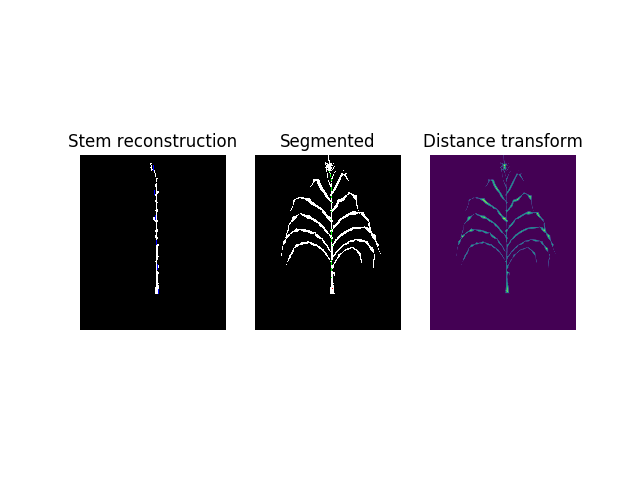

<IPython.core.display.Javascript object>


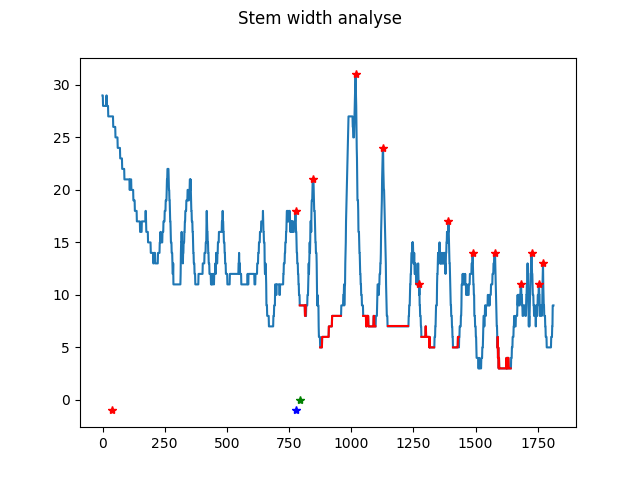

<IPython.core.display.Javascript object>


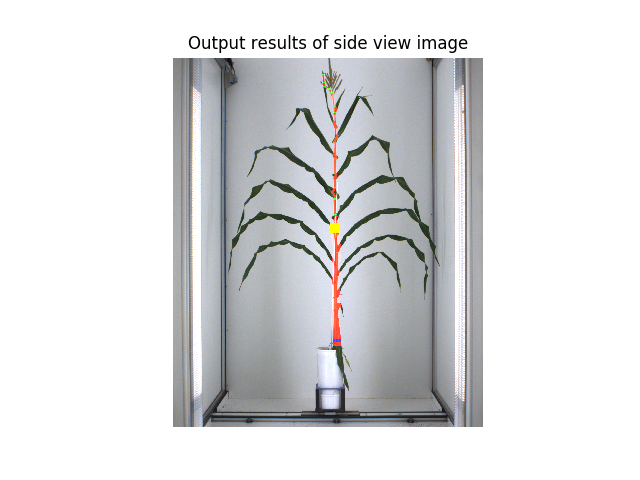

In [11]:
# show images
img_show([output_stem_img, output_binary_img, output_dt_img],
         ["Stem reconstruction", "Segmented", "Distance transform"])

fig = plt.figure()
plt.plot(distances)
plt.plot(minus_pos, -1,'r*')
plt.plot(stem_pos_after_ear, 0,'g*')
plt.plot(position, -1,'b*')
for i in pics[:,0]:
    plt.plot(i,distances[i], 'r*')
for stem in stems:
    plt.plot(range(stem[0],stem[1]),distances[stem[0]:stem[1]],'r')
fig.suptitle("Stem width analyse")
plt.show()

img_show([output_results_img[:,:,::-1]], ["Output results of side view image"])


### Detection on remaining selected side view image(s) and display

Detected position as yellow square : 


<IPython.core.display.Javascript object>


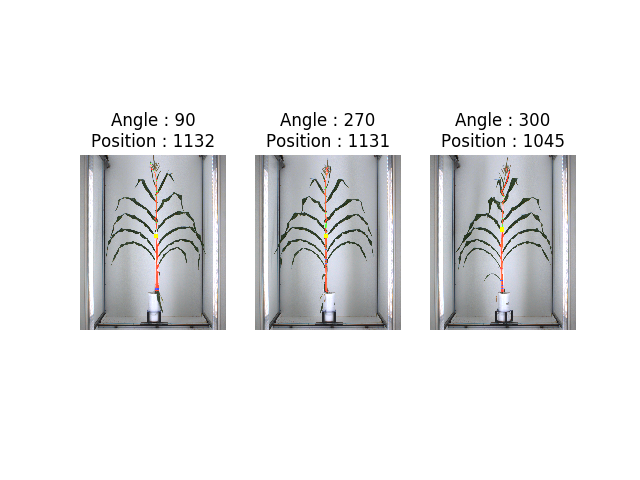

In [12]:
angle = angles_to_keep.pop(0)
plot_img = list()
plot_titles = list()
plot_img.append(output_results_img[:,:,::-1])
plot_titles.append("Angle : " + str(angle) + "\nPosition : " + str(kept_positions[0][0]))
#img_show([output_results_img[:,:,::-1]], ["Angle : " + str(angle) + "\nPos : " + str(kept_positions[0][:2])])

for angle in angles_to_keep:
    positions, imagesUtiles, side_log, img_debug = et_lib.side_analysis(binaries["side"][angle],
                                                                       images["side"][angle],
                                                                       angle,
                                                                       parameters[cabin]["side"]["pot_height"],
                                                                       parameters[cabin]["side"]["pot_width"])
    kept_positions = np.append(kept_positions, positions, axis=0)
    useful_kept_images = np.append(useful_kept_images, imagesUtiles, axis=0)
    
    image_name = "side_" + str(angle) + ".png"
    name, ext = os.path.splitext(image_name)
    plot_img.append(img_debug[name + "_result" + ext][:,:,::-1])
    plot_titles.append("Angle : " + str(angle) + "\nPosition : " + str(positions[0][0]))
    #img_show([img_debug[name + "_result" + ext][:,:,::-1]], 
    #         ["Angle : " + str(angle) + "\nPos : " + str(positions[0][:2])])

print("Detected position as yellow square : ")
img_show(plot_img, plot_titles)

## Perform a vote between results and display final(s) ear position(s)

<IPython.core.display.Javascript object>


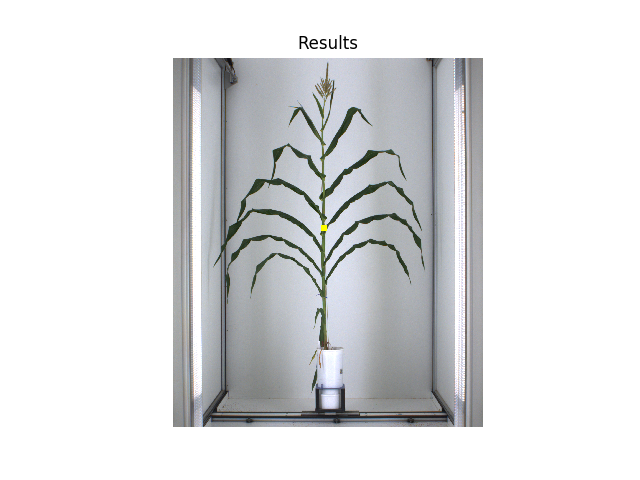

In [13]:
values = np.empty([0, 2], 'int')
im = np.empty([0], 'int')
for i in range(len(kept_positions)):
    for j in range(kept_positions[i, 2]):
        values = np.append(values, [kept_positions[i, 0:2]], axis=0)
        im = np.append(im, useful_kept_images[i])
mean_pos, finales_positions, final_kept_images = et_lib.robust_mean(values, im)
finales_positions = np.append(finales_positions, np.array([final_kept_images]).T, 1)


finale_img = images["side"][finales_positions[0, 2]].copy()
if not (mean_pos == [-1, -1]).all():
    pos = finales_positions[0, 0:2]
    finale_img[pos[0] - 20:pos[0] + 21, pos[1] - 20:pos[1] + 21, :] = [0, 255, 255]
elif finales_positions.shape[0] == 2:
    for pos in finales_positions:
        finale_img[pos[0] - 20:pos[0] + 21, pos[1] - 20:pos[1] + 21, :] = [0, 255, 255]
img_show([finale_img[:,:,::-1]], ["Results"])
